In [2]:
# =========================================================
# 📦 Imports
# =========================================================
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
import statsmodels.api as sm
from rdkit.Chem import AllChem, DataStructs
from rdkit.ML.Cluster import Butina
import warnings
warnings.filterwarnings('ignore')

# =========================================================
# SECTION 1: Load & Clean Dataset
# =========================================================
# This section loads a CSV dataset containing:
#   - Molecule IDs
#   - SMILES strings
#   - Target activity values (e.g., pChEMBL)
# It removes missing values and duplicate SMILES entries.

# ⚠️ Update this path when running for different datasets
file_path = r"PATH/TO/YOUR/DATASET.csv"

# Load dataset
df = pd.read_csv(file_path)

# Keep only essential columns
df = df[['Molecule ChEMBL ID', 'Smiles', 'pChEMBL Value']].copy()

# Remove rows with missing activity values
df.dropna(subset=['pChEMBL Value'], inplace=True)

# Ensure SMILES are strings
df['Smiles'] = df['Smiles'].astype(str)

# Remove duplicate SMILES, keeping the highest activity record
initial_shape = df.shape
df = df.sort_values('pChEMBL Value', ascending=False) \
       .drop_duplicates(subset='Smiles', keep='first')

print(f"🧹 Removed {initial_shape[0] - df.shape[0]} duplicate SMILES. New shape: {df.shape}")


🧹 Removed 103 duplicate SMILES. New shape: (319, 3)


In [4]:
# =========================================================
# SECTION 2: Descriptor Calculation
# =========================================================
# This section calculates all RDKit molecular descriptors for each compound.
# Descriptors will be used for feature selection and model building.
# Works for any dataset with SMILES strings.

# Get list of all available RDKit descriptors
descriptor_names_all = [name for name, _ in Descriptors.descList]

# Function to compute all descriptors for a given SMILES
def compute_all_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return [None] * len(descriptor_names_all)
        return [func(mol) for _, func in Descriptors.descList]
    except Exception:
        return [None] * len(descriptor_names_all)

# Apply descriptor calculation to the dataset
descriptor_values_all = df['Smiles'].apply(compute_all_descriptors)

# Convert to DataFrame with proper column names
descriptor_df_all = pd.DataFrame(descriptor_values_all.tolist(), columns=descriptor_names_all)

# Combine original dataset with descriptor data
df_full = pd.concat([df.reset_index(drop=True), descriptor_df_all], axis=1)

# Drop rows with missing descriptor values
df_full.dropna(inplace=True)

print(f"✅ Final cleaned dataset with descriptors: {df_full.shape}")


✅ Final cleaned dataset: (319, 220)


In [8]:
# =========================================================
# SECTION 3: Feature Filtering
# =========================================================
# This section performs descriptor preprocessing:
# 1. Removes constant (zero-variance) descriptors
# 2. Removes highly correlated descriptors (r > 0.80)
# The goal is to improve descriptor orthogonality and reduce redundancy.

# Separate features (X) and target variable (y)
X_all = df_full[descriptor_names_all].copy()
y_all = df_full['pChEMBL Value']

# Step 1: Remove constant descriptors
selector = VarianceThreshold(threshold=0.0)
X_nonconstant = pd.DataFrame(selector.fit_transform(X_all), 
                              columns=X_all.columns[selector.get_support()])
print(f"🧹 Removed {X_all.shape[1] - X_nonconstant.shape[1]} constant descriptors.")

# Step 2: Remove highly correlated descriptors
corr_matrix = X_nonconstant.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [col for col in upper.columns if any(upper[col] > 0.80)]
X_corr_filtered = X_nonconstant.drop(columns=to_drop_corr)

print(f"🔗 Removed {len(to_drop_corr)} highly correlated descriptors (r > 0.80).")
print(f"🔬 Remaining descriptors after filtering: {X_corr_filtered.shape[1]}")


🧹 Removed 35 constant descriptors.
🔗 Removed 75 highly correlated descriptors (r > 0.80).
🔬 Remaining descriptors: 107


In [10]:
# =========================================================
# SECTION 4: Variance Inflation Factor (VIF) Filtering
# =========================================================
# Purpose:
# - Remove descriptors with high multicollinearity (VIF > threshold)
# - Improves model stability and interpretability in QSAR workflows

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X_df):
    """
    Calculate Variance Inflation Factor (VIF) for each feature.
    Args:
        X_df (pd.DataFrame): Dataframe of numerical features
    Returns:
        pd.DataFrame: Features with their corresponding VIF values
    """
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_df.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X_df.values, i) 
        for i in range(X_df.shape[1])
    ]
    return vif_data

# Copy filtered feature set from Section 3
X_vif = X_corr_filtered.copy()

# Tracking dropped features
vif_dropped = []
vif_threshold = 5  # 🛡️ Stricter threshold recommended for QSAR

print("🚦 Starting VIF filtering...")
while True:
    vif_df = calculate_vif(X_vif)
    max_vif = vif_df['VIF'].max()
    if max_vif > vif_threshold:
        drop_feature = vif_df.sort_values('VIF', ascending=False).iloc[0]['Feature']
        X_vif.drop(columns=[drop_feature], inplace=True)
        vif_dropped.append((drop_feature, round(max_vif, 2)))
        print(f"⚠️ Dropped: {drop_feature} (VIF={round(max_vif, 2)}) — {X_vif.shape[1]} features remain")
    else:
        print(f"✅ All VIF values are acceptable (≤ {vif_threshold}).")
        break

# Summary
if vif_dropped:
    print(f"\n📉 VIF Filter Summary — Dropped {len(vif_dropped)} descriptors:")
    for name, vif_val in vif_dropped:
        print(f"   - {name} (VIF={vif_val})")

print(f"\n📦 Final descriptor count after VIF filtering: {X_vif.shape[1]}")


🚦 Starting VIF filtering...
⚠️ Dropped: MolWt (VIF=253277.24) — 106 features remain
⚠️ Dropped: BCUT2D_LOGPHI (VIF=35285.99) — 105 features remain
⚠️ Dropped: RingCount (VIF=30041.24) — 104 features remain
⚠️ Dropped: BCUT2D_MWLOW (VIF=18427.55) — 103 features remain
⚠️ Dropped: HallKierAlpha (VIF=16081.51) — 102 features remain
⚠️ Dropped: BCUT2D_CHGHI (VIF=13133.62) — 101 features remain
⚠️ Dropped: BCUT2D_LOGPLOW (VIF=9327.91) — 100 features remain
⚠️ Dropped: PEOE_VSA7 (VIF=7617.69) — 99 features remain
⚠️ Dropped: MolLogP (VIF=6836.96) — 98 features remain
⚠️ Dropped: TPSA (VIF=5262.36) — 97 features remain
⚠️ Dropped: VSA_EState2 (VIF=2690.51) — 96 features remain
⚠️ Dropped: AvgIpc (VIF=1807.02) — 95 features remain
⚠️ Dropped: SMR_VSA3 (VIF=1490.32) — 94 features remain
⚠️ Dropped: PEOE_VSA1 (VIF=1229.52) — 93 features remain
⚠️ Dropped: BCUT2D_MRHI (VIF=1181.97) — 92 features remain
⚠️ Dropped: SPS (VIF=1061.02) — 91 features remain
⚠️ Dropped: SMR_VSA10 (VIF=942.87) — 90 feat


✅ Best descriptor count: 8 | R² = 0.6339, RMSE = 0.7376, MAE = 0.5835

📊 Publication-Ready Validation Metrics
—————————————————————————————————————————————
Internal Validation:
  R²: 0.9449
  Adjusted R²: 0.9431
  Q² (LOO): 0.6032
  RMSE (LOO): 0.7999
  CCC (Train): 0.9688

External Validation:
  R² (Test): 0.6339
  RMSE (Test): 0.7376
  CCC (Test): 0.7880
  k': 0.9984
  k: 0.9884

Y-Randomization:
  Mean R² (Random): -0.2304
  cR²p: 0.7800
  ✅ Model is statistically robust (cR²p > 0.5)


NameError: name 'best_r2' is not defined

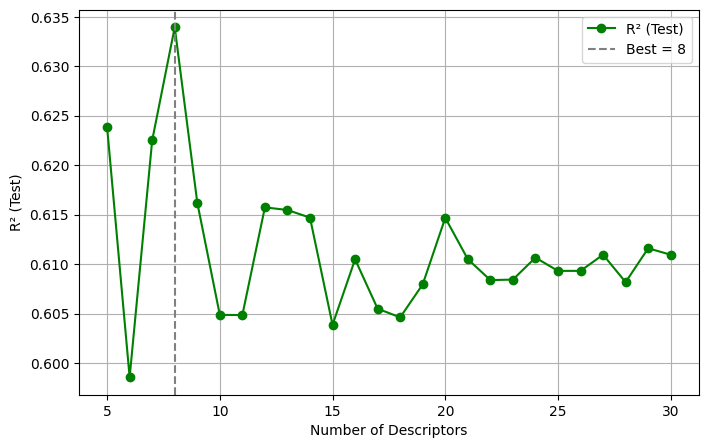

In [13]:
# =========================================================
# SECTION X: Descriptor Selection & Random Forest QSAR Model
# =========================================================
# Purpose:
# 1. Rank descriptors by importance (Random Forest feature importance)
# 2. Select optimal descriptor count via R² (Test)
# 3. Train final model and perform internal/external validation
# 4. Conduct Y-randomization test for robustness

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

# --------------------------------------
# Utility Functions
# --------------------------------------
def adjusted_r2(r2, n, p):
    """Calculate Adjusted R²"""
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

def concordance_cc(y_true, y_pred):
    """Concordance Correlation Coefficient"""
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    cov = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    return (2 * cov) / (sd_true**2 + sd_pred**2 + (mean_true - mean_pred)**2)

def loo_q2(model, X, y):
    """Leave-One-Out Q² and RMSE"""
    loo = LeaveOneOut()
    y_true, y_pred = [], []
    for train_idx, test_idx in loo.split(X):
        model.fit(X[train_idx], y.iloc[train_idx])
        y_pred.append(model.predict(X[test_idx])[0])
        y_true.append(y.iloc[test_idx].values[0])
    q2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return q2, rmse

# --------------------------------------
# 1. Feature Importance Ranking
# --------------------------------------
rf_initial = RandomForestRegressor(n_estimators=200, random_state=42)
rf_initial.fit(X_vif, y_all)
feature_importance = pd.Series(rf_initial.feature_importances_, index=X_vif.columns).sort_values(ascending=False)

# --------------------------------------
# 2. Optimal Descriptor Count Search
# --------------------------------------
metrics = []
descriptor_counts = range(5, min(30, len(feature_importance)) + 1)

for n in descriptor_counts:
    top_features = feature_importance.head(n).index.tolist()
    X_selected = X_vif[top_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y_all, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred_test = model.predict(X_test_scaled)

    metrics.append({
        "n_descriptors": n,
        "R2_test": r2_score(y_test, y_pred_test),
        "RMSE_test": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "MAE_test": mean_absolute_error(y_test, y_pred_test)
    })

df_metrics = pd.DataFrame(metrics)
best_row = df_metrics.sort_values(by="R2_test", ascending=False).iloc[0]
best_n = int(best_row["n_descriptors"])
top_features_final = feature_importance.head(best_n).index.tolist()

print(f"\n✅ Best descriptor count: {best_n} | R² = {best_row['R2_test']:.4f}, RMSE = {best_row['RMSE_test']:.4f}, MAE = {best_row['MAE_test']:.4f}")

# --------------------------------------
# 3. Final Model Training & Validation
# --------------------------------------
X_final = X_vif[top_features_final]
X_train, X_test, y_train, y_test = train_test_split(X_final, y_all, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

final_model = RandomForestRegressor(n_estimators=200, random_state=42)
final_model.fit(X_train_scaled, y_train)
y_train_pred = final_model.predict(X_train_scaled)
y_test_pred = final_model.predict(X_test_scaled)

# Internal Validation
r2_train = r2_score(y_train, y_train_pred)
adj_r2_train = adjusted_r2(r2_train, len(y_train), best_n)
q2_loo, rmse_loo = loo_q2(RandomForestRegressor(n_estimators=200, random_state=42), X_train_scaled, y_train)
ccc_train = concordance_cc(y_train, y_train_pred)

# External Validation
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
ccc_test = concordance_cc(y_test, y_test_pred)

k_prime = LinearRegression(fit_intercept=False).fit(y_test_pred.reshape(-1, 1), y_test.to_numpy()).coef_[0]
k = LinearRegression(fit_intercept=False).fit(y_test.to_numpy().reshape(-1, 1), y_test_pred).coef_[0]

# --------------------------------------
# 4. Y-Randomization Test
# --------------------------------------
r2_randomized = []
n_permutations = 100
for i in range(n_permutations):
    y_random = shuffle(y_all, random_state=i)
    _, y_test_r = train_test_split(y_random, test_size=0.2, random_state=42)
    model_r = RandomForestRegressor(n_estimators=200, random_state=42)
    model_r.fit(X_train_scaled, y_train)
    y_pred_r = model_r.predict(X_test_scaled)
    r2_randomized.append(r2_score(y_test_r, y_pred_r))

mean_r2_random = np.mean(r2_randomized)
c_r2p = r2_test * (1 - mean_r2_random)

# --------------------------------------
# 5. Metrics Output
# --------------------------------------
print("\n📊 Publication-Ready Validation Metrics")
print("—" * 45)
print(f"Internal Validation:\n  R²: {r2_train:.4f}\n  Adjusted R²: {adj_r2_train:.4f}\n  Q² (LOO): {q2_loo:.4f}\n  RMSE (LOO): {rmse_loo:.4f}\n  CCC (Train): {ccc_train:.4f}\n")
print(f"External Validation:\n  R² (Test): {r2_test:.4f}\n  RMSE (Test): {rmse_test:.4f}\n  CCC (Test): {ccc_test:.4f}\n  k': {k_prime:.4f}\n  k: {k:.4f}\n")
print(f"Y-Randomization:\n  Mean R² (Random): {mean_r2_random:.4f}\n  cR²p: {c_r2p:.4f}")
if c_r2p > 0.5:
    print("  ✅ Model is statistically robust (cR²p > 0.5)")
else:
    print("  ⚠️ Model may not be robust (cR²p ≤ 0.5)")

# --------------------------------------
# 6. Plot Best Descriptor Count vs R²
# --------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(df_metrics["n_descriptors"], df_metrics["R2_test"], marker='o', label='R² (Test)', color='green')
plt.axvline(best_n, color='gray', linestyle='--', label=f'Best = {best_n}')
plt.xlabel("Number of Descriptors")
plt.ylabel("R² (Test)")
plt.legend()
plt.grid(True)
text_x = best_n + 1 if best_n < 25 else best_n - 5
plt.text(text_x, best_row["R2_test"] - 0.035,
         f"R² = {best_row['R2_test']:.3f}\nRMSE = {best_row['RMSE_test']:.3f}\nMAE = {best_row['MAE_test']:.3f}",
         fontsize=9, bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.6))

# Save plot to repo
os.makedirs("plots", exist_ok=True)
plt.tight_layout()
plt.savefig(os.path.join("plots", "Best_R2_vs_Descriptor_Count.tiff"), dpi=300)
plt.show()


✅ Original R²: 0.6339


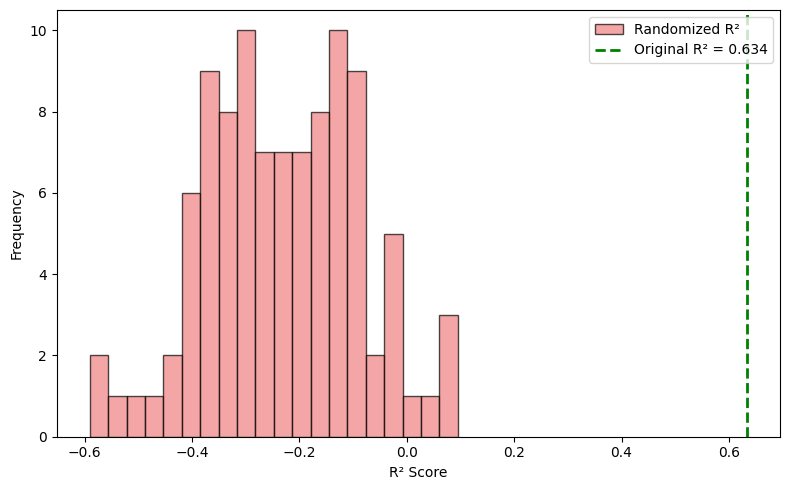


🎯 Y-randomization summary:
Number of randomized models with R² ≥ original: 0 / 100


In [17]:
# ==================================================
# SECTION X: Y-RANDOMIZATION TEST
# ==================================================
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os

# ✅ Ensure 'X_vif', 'top_features_final', and 'y_all' are already defined from previous sections
X_selected = X_vif[top_features_final]
y_true = y_all.copy()

# --- Original model performance ---
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_true, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

original_model = RandomForestRegressor(n_estimators=200, random_state=42)
original_model.fit(X_train_scaled, y_train)
y_pred = original_model.predict(X_test_scaled)

original_r2 = r2_score(y_test, y_pred)
print(f"✅ Original R²: {original_r2:.4f}")

# --- Y-Randomization ---
n_iterations = 100
r2_randomized = []

for i in range(n_iterations):
    y_shuffled = shuffle(y_true, random_state=i)
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_selected, y_shuffled, test_size=0.2, random_state=42)
    
    scaler_r = StandardScaler()
    X_train_r_scaled = scaler_r.fit_transform(X_train_r)
    X_test_r_scaled = scaler_r.transform(X_test_r)
    
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train_r_scaled, y_train_r)
    y_pred_r = model.predict(X_test_r_scaled)
    r2_randomized.append(r2_score(y_test_r, y_pred_r))

# --- Plot distribution ---
plt.figure(figsize=(8, 5))
plt.hist(r2_randomized, bins=20, color='lightcoral', edgecolor='black', alpha=0.7, label="Randomized R²")
plt.axvline(original_r2, color='green', linestyle='--', linewidth=2, label=f"Original R² = {original_r2:.3f}")
plt.xlabel("R² Score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()

# --- Save plot ---
plot_dir = os.path.join("plots")
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(os.path.join(plot_dir, "Y_randomization.tiff"), dpi=300, format='tiff')
plt.show()

# --- Interpretation ---
count_better = sum(r >= original_r2 for r in r2_randomized)
print(f"\n🎯 Y-randomization summary:")
print(f"Number of randomized models with R² ≥ original: {count_better} / {n_iterations}")


In [19]:
from sklearn.utils import shuffle

# ✅ Final train/test split using selected descriptors
X_train, X_test, y_train, y_test = train_test_split(X_final, y_all, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Train final model on real data
final_model = RandomForestRegressor(n_estimators=200, random_state=42)
final_model.fit(X_train_scaled, y_train)
y_pred_final = final_model.predict(X_test_scaled)
r2_original = r2_score(y_test, y_pred_final)

# ✅ Y-randomization loop
r2_randomized = []
n_permutations = 100

for i in range(n_permutations):
    y_random = shuffle(y_all, random_state=i)
    y_train_r, y_test_r = train_test_split(y_random, test_size=0.2, random_state=42)
    
    model_r = RandomForestRegressor(n_estimators=200, random_state=42)
    model_r.fit(X_train_scaled, y_train_r)  # keep X the same
    y_pred_r = model_r.predict(X_test_scaled)
    
    r2_randomized.append(r2_score(y_test_r, y_pred_r))

# ✅ Compute cR²p
mean_r2_random = np.mean(r2_randomized)
c_r2p = r2_original * (1 - mean_r2_random)

print("\n🎯 Y-Randomization Summary:")
print(f"Original R² on Test Set: {r2_original:.4f}")
print(f"Mean R² from Randomized Models: {mean_r2_random:.4f}")
print(f"Y-Randomization Coefficient (cR²p): {c_r2p:.4f}")

# ✅ Interpretation
if c_r2p > 0.5:
    print("✅ Model is statistically robust (cR²p > 0.5).")
else:
    print("⚠️ Model may not be robust (cR²p ≤ 0.5). Consider descriptor refinement or more data.")



🎯 Y-Randomization Summary:
Original R² on Test Set: 0.6339
Mean R² from Randomized Models: -0.2304
Y-Randomization Coefficient (cR²p): 0.7800
✅ Model is statistically robust (cR²p > 0.5).


In [14]:
# ==========================================
# 📌 Multicollinearity Check for Final Selected Descriptors
# ==========================================

# Ensure calculate_vif function from earlier section is available
vif_final_df = calculate_vif(X_final)

# Display VIF values sorted in ascending order
print("\n📌 Variance Inflation Factor (VIF) for Final Selected Descriptors:")
print(vif_final_df.sort_values(by="VIF", ascending=True))


📌 VIF for Final Selected Descriptors:
                Feature       VIF
2          BCUT2D_MRLOW  1.129719
1                   Ipc  1.283337
7           VSA_EState5  1.413725
5  NumAtomStereoCenters  1.496481
0           fr_pyridine  1.850181
6            SlogP_VSA7  2.131225
4             PEOE_VSA4  2.205332
3            PEOE_VSA11  2.223907


In [16]:
# ==========================================
# 📊 Mean Effect Analysis for Final Selected Descriptors
# ==========================================

# Ensure rf_initial (from feature selection step) and X_final are already defined
means = X_final.mean()
stdevs = X_final.std()

# Extract feature importances only for the selected descriptors
betas = rf_initial.feature_importances_[:len(X_final.columns)]

# Calculate Mean Effect
mean_effects = (betas * means) / stdevs

# Create summary DataFrame
mean_effect_df = pd.DataFrame({
    'Descriptor': X_final.columns,
    'Mean': means.values,
    'Std': stdevs.values,
    'Importance': betas,
    'Mean Effect': mean_effects
})

# Display sorted table
print("\n📊 Mean Effect Summary:")
print(mean_effect_df.sort_values(by='Mean Effect', ascending=False))



📊 Mean Effect Summary:
                                Descriptor          Mean           Std  \
PEOE_VSA11                      PEOE_VSA11  4.457551e+00  4.783276e+00   
PEOE_VSA4                        PEOE_VSA4  5.767328e+00  6.778567e+00   
fr_pyridine                    fr_pyridine  4.733542e-01  7.082699e-01   
BCUT2D_MRLOW                  BCUT2D_MRLOW  1.931550e-02  2.053915e-01   
Ipc                                    Ipc  6.383330e+07  9.384127e+08   
NumAtomStereoCenters  NumAtomStereoCenters  2.664577e-01  5.617557e-01   
SlogP_VSA7                      SlogP_VSA7  5.360846e+00  3.937586e+00   
VSA_EState5                    VSA_EState5  6.763622e-02  8.854134e-01   

                      Importance  Mean Effect  
PEOE_VSA11              0.079965     0.074520  
PEOE_VSA4               0.057769     0.049151  
fr_pyridine             0.043432     0.029027  
BCUT2D_MRLOW            0.168956     0.015889  
Ipc                     0.112973     0.007685  
NumAtomStereoCenters 

In [18]:
# ===== SECTION: Data Splitting and Initial Model Evaluation =====
X_train, X_test, y_train, y_test = train_test_split(X_final, y_all, test_size=0.2, random_state=42)
print(f"\n✅ Training set size: {X_train.shape}, Test set size: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Support Vector Regression": SVR(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "KNN Regressor": KNeighborsRegressor()
}

results_train_test = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    results_train_test.append({
        "Model": name,
        "R² (Train)": r2_score(y_train, y_train_pred),
        "MSE (Train)": mean_squared_error(y_train, y_train_pred),
        "MAE (Train)": mean_absolute_error(y_train, y_train_pred),
        "R² (Test)": r2_score(y_test, y_test_pred),
        "MSE (Test)": mean_squared_error(y_test, y_test_pred),
        "MAE (Test)": mean_absolute_error(y_test, y_test_pred)
    })

results_train_test_df = pd.DataFrame(results_train_test).sort_values(by="R² (Test)", ascending=False)
print("\n📊 Model Performance on Train and Test Set (Before Tuning):")
print(results_train_test_df.to_string(index=False))



✅ Training set size: (255, 8), Test set size: (64, 8)

📊 Model Performance on Train and Test Set (Before Tuning):
                    Model  R² (Train)  MSE (Train)  MAE (Train)  R² (Test)  MSE (Test)  MAE (Test)
            Random Forest    0.940547     0.095880     0.221582   0.633601    0.544608    0.580078
        Gradient Boosting    0.926872     0.117933     0.275631   0.605079    0.587001    0.559705
            KNN Regressor    0.659337     0.549386     0.536933   0.599679    0.595027    0.629156
Support Vector Regression    0.699423     0.484740     0.472315   0.479356    0.773873    0.674637
         Ridge Regression    0.565219     0.701170     0.642649   0.443267    0.827516    0.706567
        Linear Regression    0.565224     0.701162     0.642779   0.443182    0.827641    0.706890
         Lasso Regression    0.000000     1.612697     1.040658  -0.027930    1.527891    0.962041


In [20]:
# ===== SECTION: Model Cross-Validation =====
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for name, model in models.items():
    scores = cross_validate(
        model, X_train_scaled, y_train, cv=cv,
        scoring={
            'r2': make_scorer(r2_score),
            'mse': make_scorer(mean_squared_error),
            'mae': make_scorer(mean_absolute_error)
        },
        return_train_score=False
    )
    cv_results.append({
        "Model": name,
        "CV R² (Train)": np.mean(scores['test_r2']),
        "CV MSE (Train)": np.mean(scores['test_mse']),
        "CV MAE (Train)": np.mean(scores['test_mae'])
    })

df_cv = pd.DataFrame(cv_results).sort_values(by="CV R² (Train)", ascending=False)
print("\n📈 5-Fold Cross-Validation Results:")
print(df_cv.to_string(index=False))


📈 5-Fold Cross-Validation Results:
                    Model  CV R² (Train)  CV MSE (Train)  CV MAE (Train)
        Gradient Boosting       0.560851        0.692418        0.619660
Support Vector Regression       0.559654        0.704829        0.620172
            Random Forest       0.548872        0.716157        0.606636
            KNN Regressor       0.514186        0.771211        0.620627
         Ridge Regression       0.297626        1.038765        0.699132
         Lasso Regression      -0.000581        1.613078        1.040620
        Linear Regression     -25.983127       32.997588        1.024264


In [22]:
# ===== SECTION: Hyperparameter Optimization =====
from sklearn.model_selection import GridSearchCV

# Define models and parameter grids for tuning
param_grids = {
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }
    },
    "KNN": {
        "model": KNeighborsRegressor(),
        "params": {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    },
    "Ridge": {
        "model": Ridge(),
        "params": {
            'alpha': [0.01, 0.1, 1, 10, 100]
        }
    }
}

# Fit Linear Regression (no tuning needed)
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Perform GridSearchCV for hyperparameter tuning
tuned_models = {}
for name, entry in param_grids.items():
    print(f"\n🔍 Tuning {name}...")
    grid = GridSearchCV(entry["model"], entry["params"], cv=5, scoring="r2", n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    tuned_models[name] = grid


🔍 Tuning Random Forest...

🔍 Tuning Gradient Boosting...

🔍 Tuning SVR...

🔍 Tuning KNN...

🔍 Tuning Ridge...


In [24]:
# ===== SECTION: Evaluation of Tuned Models =====
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    if hasattr(model, "best_estimator_"):
        estimator = model.best_estimator_
        best_params = model.best_params_
    else:
        estimator = model
        best_params = "N/A"
    
    y_train_pred = estimator.predict(X_train)
    y_test_pred = estimator.predict(X_test)
    
    return {
        "Model": name,
        "R² (Train)": r2_score(y_train, y_train_pred),
        "R² (Test)": r2_score(y_test, y_test_pred),
        "MSE (Test)": mean_squared_error(y_test, y_test_pred),
        "MAE (Test)": mean_absolute_error(y_test, y_test_pred),
        "Best Params": best_params
    }

# Evaluate all tuned models
results = []
for name, grid in tuned_models.items():
    results.append(evaluate_model(name, grid, X_train_scaled, X_test_scaled, y_train, y_test))

# Include evaluation for linear regression (no tuning)
results.append(evaluate_model("Linear Regression", linear_model, X_train_scaled, X_test_scaled, y_train, y_test))

# Convert results to DataFrame and sort
eval_df = pd.DataFrame(results)
eval_df_sorted = eval_df.sort_values(by="R² (Test)", ascending=False).reset_index(drop=True)

# Display evaluation summary
print("\n📈 Model Comparison Summary (After Hyperparameter Tuning):")
print(eval_df_sorted[["Model", "R² (Train)", "R² (Test)", "MSE (Test)", "MAE (Test)", "Best Params"]].to_string(index=False))

# Identify best model
best_model_row = eval_df_sorted.iloc[0]
best_model_name = best_model_row["Model"]
print(f"\n✅ Selected Best Model: {best_model_name}")


📈 Model Comparison Summary (After Hyperparameter Tuning):
            Model  R² (Train)  R² (Test)  MSE (Test)  MAE (Test)                                                                           Best Params
    Random Forest    0.895557   0.650167    0.519984    0.573410 {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Gradient Boosting    0.880811   0.623528    0.559580    0.574065                          {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
              KNN    0.644324   0.583099    0.619672    0.627679                                      {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
              SVR    0.699423   0.479356    0.773873    0.674637                                            {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
            Ridge    0.564743   0.443637    0.826965    0.704486                                                                         {'alpha': 10}
Linear Regression    0.565224   0.4

In [35]:
# ===== SECTION: Cross-Validation of Tuned Models =====
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for name, model in tuned_models.items():
    scores = cross_validate(
        model, X_train_scaled, y_train, cv=cv,
        scoring={
            'r2': make_scorer(r2_score),
            'mse': make_scorer(mean_squared_error),
            'mae': make_scorer(mean_absolute_error)
        },
        return_train_score=False
    )
    cv_results.append({
        "Model": name,
        "CV R²": np.mean(scores['test_r2']),
        "CV MSE": np.mean(scores['test_mse']),
        "CV MAE": np.mean(scores['test_mae'])
    })

df_cv = pd.DataFrame(cv_results).sort_values(by="CV R²", ascending=False)
print("\n📈 5-Fold Cross-Validation Results After Tuning:")
print(df_cv.to_string(index=False))


📈 5-Fold Cross-Validation Results After Tuning:
            Model     CV R²    CV MSE   CV MAE
              SVR  0.543324  0.735858 0.635680
    Random Forest  0.543091  0.739370 0.613637
Gradient Boosting  0.523351  0.770118 0.632972
              KNN  0.508150  0.785288 0.638809
            Ridge -9.657549 13.167774 0.916900


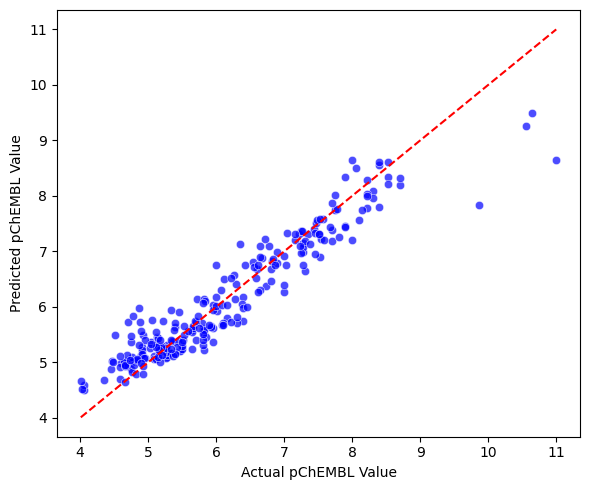

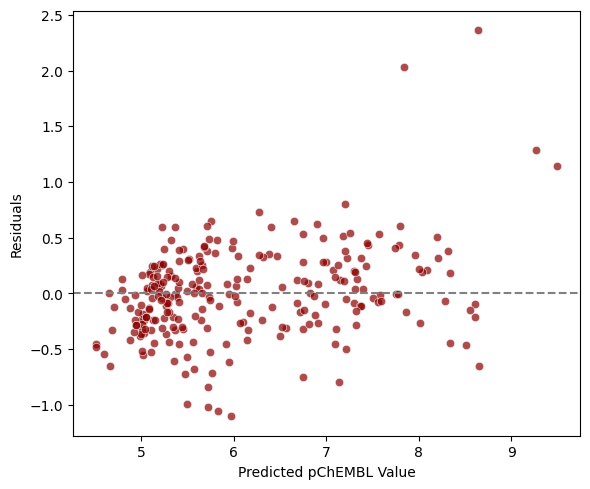

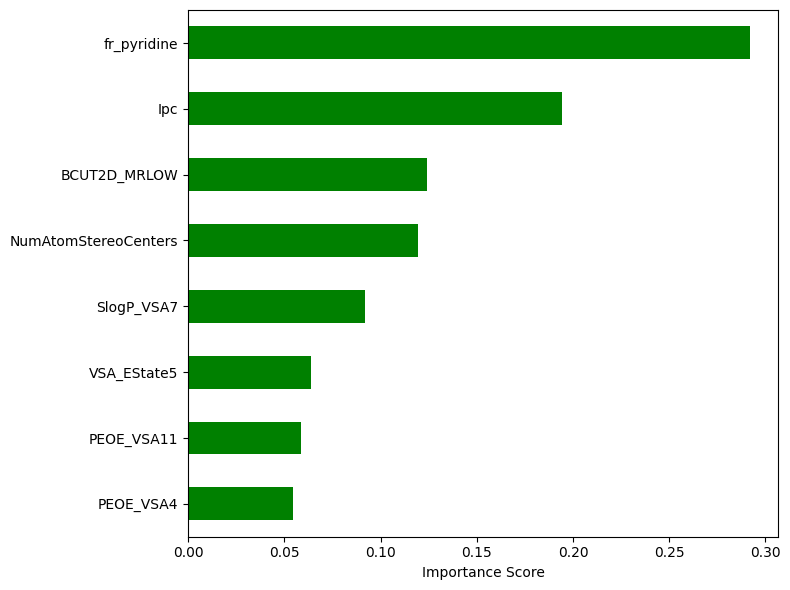

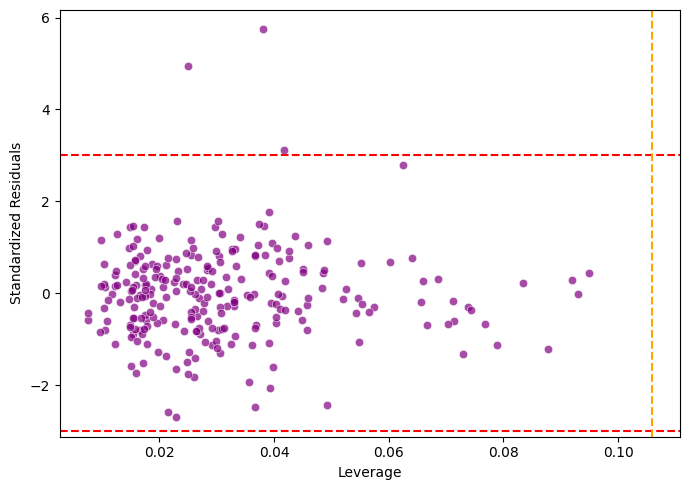

✅ All plots generated and saved as TIFF in:
C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\4\\Plots


In [35]:
# ===== SECTION: Diagnostic and Feature Importance Plots for Selected Model =====
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

# TODO: Replace this placeholder path with your desired directory path
save_dir = r"YOUR/PATH/TO/SAVE/PLOTS"
os.makedirs(save_dir, exist_ok=True)

# Initialize and fit the selected Random Forest model with chosen hyperparameters
model_rf_final = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42
)
model_rf_final.fit(X_train_scaled, y_train)

# Predictions and residuals
y_pred_rf = model_rf_final.predict(X_train_scaled)
residuals = y_train - y_pred_rf
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Leverage calculation
X_rf_const = sm.add_constant(X_train_scaled)
hat_matrix = X_rf_const @ np.linalg.inv(X_rf_const.T @ X_rf_const) @ X_rf_const.T
leverage = np.diag(hat_matrix)
n, p = X_train_scaled.shape
leverage_threshold = 3 * (p + 1) / n

# Feature importance extraction
importances = model_rf_final.feature_importances_
top_features_plot = pd.Series(importances, index=top_features_final).sort_values(ascending=False)

# Plot: Actual vs Predicted
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_train, y=y_pred_rf, color='blue', alpha=0.7)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual pChEMBL Value")
plt.ylabel("Predicted pChEMBL Value")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Actual_vs_Predicted.tiff"), dpi=300)
plt.show()

# Plot: Residuals vs Predicted
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_pred_rf, y=residuals, color='darkred', alpha=0.7)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted pChEMBL Value")
plt.ylabel("Residuals")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Residuals.tiff"), dpi=300)
plt.show()

# Plot: Feature Importance Bar Chart
plt.figure(figsize=(8, 6))
top_features_plot.sort_values().plot(kind='barh', color='green')
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Feature_Importance.tiff"), dpi=300)
plt.show()

# Plot: Williams Plot (Leverage vs Standardized Residuals) with outlier filtering
max_lev = np.percentile(leverage, 99.5)
mask = leverage < max_lev

plt.figure(figsize=(7, 5))
sns.scatterplot(x=leverage[mask], y=standardized_residuals[mask], color='purple', alpha=0.7)
plt.axhline(3, linestyle='--', color='red')
plt.axhline(-3, linestyle='--', color='red')
plt.axvline(leverage_threshold, linestyle='--', color='orange')
plt.xlabel("Leverage")
plt.ylabel("Standardized Residuals")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Williams_Plot_Filtered.tiff"), dpi=300)
plt.show()

print(f"✅ All diagnostic and feature importance plots generated and saved in:\n{save_dir}")


In [26]:
# ===== SECTION: Save Predictions and Select Top Compounds Using Tuned Model =====
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import pandas as pd
import numpy as np
import os

# Step 1: Use top descriptors from final model selection
X_top20 = X_final.copy()
y_final = y_all.loc[X_top20.index]  # Ensure alignment
ids = df_full.loc[X_top20.index, 'Molecule ChEMBL ID']
smiles = df_full.loc[X_top20.index, 'Smiles']

# Step 2: Scale the features
scaler_final = StandardScaler()
X_scaled_final = scaler_final.fit_transform(X_top20)

# Step 3: Train Best Model — Tuned Random Forest
model_best = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=2,
    random_state=42
)
model_best.fit(X_scaled_final, y_final)

# Step 4: Predict and calculate residuals
y_pred_best = model_best.predict(X_scaled_final)
residuals_best = y_final - y_pred_best

# Step 5: Leverage calculation
X_const_final = sm.add_constant(X_scaled_final)
hat_matrix_best = X_const_final @ np.linalg.inv(X_const_final.T @ X_const_final) @ X_const_final.T
leverage_best = np.diag(hat_matrix_best)

# Step 6: Combine all results into a DataFrame
results_df = pd.DataFrame({
    'Molecule ChEMBL ID': ids.values,
    'Smiles': smiles.values,
    'Actual pChEMBL': y_final.values,
    'Predicted pChEMBL': y_pred_best,
    'Residuals': residuals_best,
    'Leverage': leverage_best
})

# Add descriptor values to the table
for feature in X_top20.columns:
    results_df[feature] = X_top20[feature].values

# Step 7: Apply applicability domain filter (leverage threshold)
h_star = 3 * (X_top20.shape[1] + 1) / X_top20.shape[0]
within_domain_df = results_df[results_df['Leverage'] <= h_star].copy()

# Step 8: Extract top 20 predicted compounds within applicability domain
top20_compounds = within_domain_df.sort_values(by='Predicted pChEMBL', ascending=False).head(20).reset_index(drop=True)

# Step 9: Save results
# TODO: Replace this placeholder path with your desired directory
save_path = r"YOUR/PATH/TO/SAVE/RESULTS"
os.makedirs(save_path, exist_ok=True)

results_df.to_csv(os.path.join(save_path, "Full_Prediction_Results_BestModel.csv"), index=False)
top20_compounds.to_csv(os.path.join(save_path, "Top20_BestModel_Predicted_Compounds.csv"), index=False)

# Step 10: Output preview
print("\n📊 Full Dataset with Predictions and Descriptors:")
print(results_df.head())

print("\n💎 Top 20 Predicted Compounds Within Applicability Domain:")
print(top20_compounds[['Molecule ChEMBL ID', 'Smiles', 'Predicted pChEMBL']])

print("\n✅ Saved to:")
print("- Full_Prediction_Results_BestModel.csv")
print("- Top20_BestModel_Predicted_Compounds.csv")


📊 Full Dataset with Predictions and Descriptors:
  Molecule ChEMBL ID                                             Smiles  \
0      CHEMBL3806279  CO[C@@H](C)c1c(NC(=O)Nc2cncc(C(F)(F)F)c2)cnc2c...   
1      CHEMBL3806155  CO[C@@H](C)c1c(NC(=O)Nc2cnc(-n3nccn3)c(C(F)(F)...   
2      CHEMBL3805390  COCC(c1c(NC(=O)Nc2cnc(-n3nccn3)c(Cl)c2)cnc2cc(...   
3      CHEMBL3806235  O=C(Nc1cnc(-n2nccn2)c(C(F)(F)F)c1)Nc1cnc2cc(Cl...   
4      CHEMBL3806299  CC(C)c1c(NC(=O)Nc2ccc(-n3cc(CN)cn3)c(Cl)c2)cnc...   

   Actual pChEMBL  Predicted pChEMBL  Residuals  Leverage  fr_pyridine  \
0           11.00           8.647135   2.352865  0.030834          1.0   
1           10.64          10.003120   0.636880  0.048615          1.0   
2           10.55           9.328646   1.221354  0.034279          1.0   
3           10.03          10.037653  -0.007653  0.048416          1.0   
4            9.87           7.894928   1.975072  0.020653          0.0   

            Ipc  BCUT2D_MRLOW  PEOE_VSA11  PEOE_VSA4  

⚠️ Leverage threshold (h*): 0.0846
🧪 Total compounds within applicability domain: 317
🔥 Top 50% high-activity compounds within domain: 158
💊 Drug-like compounds after activity + domain filter: 122


[16:11:01] DEPRECATION WARNING: please use MorganGenerator
[16:11:01] DEPRECATION WARNING: please use MorganGenerator
[16:11:01] DEPRECATION WARNING: please use MorganGenerator
[16:11:01] DEPRECATION WARNING: please use MorganGenerator
[16:11:01] DEPRECATION WARNING: please use MorganGenerator
[16:11:01] DEPRECATION WARNING: please use MorganGenerator
[16:11:01] DEPRECATION WARNING: please use MorganGenerator
[16:11:01] DEPRECATION WARNING: please use MorganGenerator
[16:11:01] DEPRECATION WARNING: please use MorganGenerator
[16:11:01] DEPRECATION WARNING: please use MorganGenerator
[16:11:01] DEPRECATION WARNING: please use MorganGenerator
[16:11:01] DEPRECATION WARNING: please use MorganGenerator
[16:11:01] DEPRECATION WARNING: please use MorganGenerator
[16:11:01] DEPRECATION WARNING: please use MorganGenerator
[16:11:01] DEPRECATION WARNING: please use MorganGenerator
[16:11:01] DEPRECATION WARNING: please use MorganGenerator
[16:11:01] DEPRECATION WARNING: please use MorganGenerat

🔗 Total clusters formed: 8
🧬 Selected 8 diverse cluster representatives for docking.


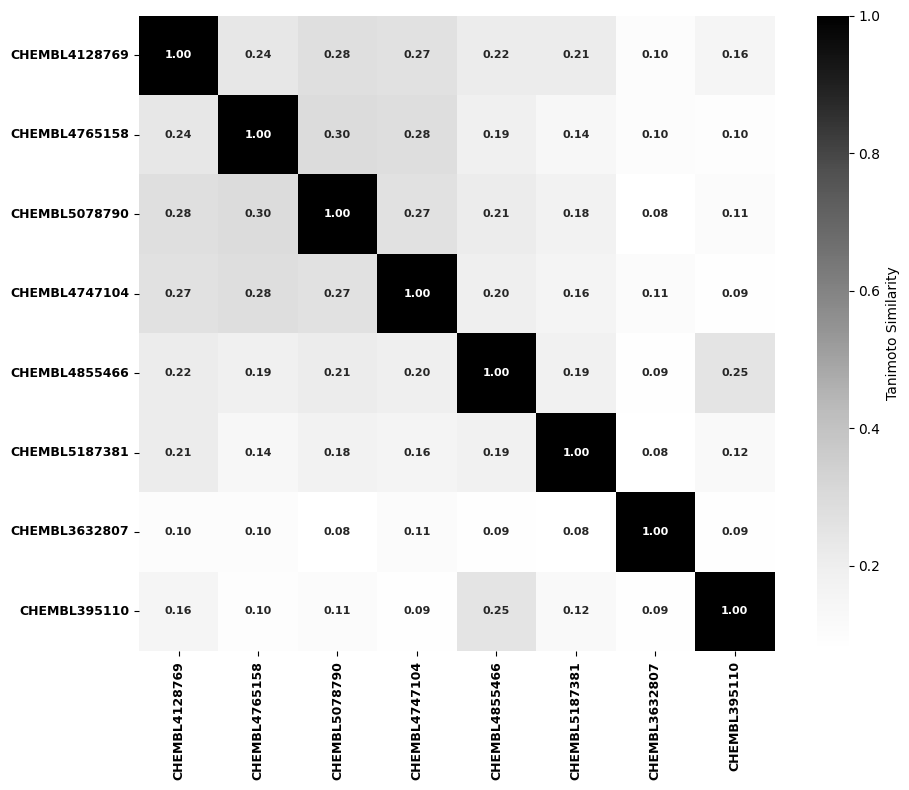


✅ Docking list and heatmap saved to:
C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\4


In [34]:
# ===== SECTION: Activity Filtering, Drug-Likeness, Clustering, and Docking Compound Selection =====
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Crippen
from rdkit.ML.Cluster import Butina
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# Step 1: Merge prediction, residual, leverage
df_preds = df_full.copy()
df_preds['Predicted pChEMBL'] = y_pred_best
df_preds['Residuals'] = residuals_best
df_preds['Leverage'] = leverage_best

# Step 2: Compute leverage threshold
h_star = 3 * (X_top20.shape[1] + 1) / X_top20.shape[0]
print(f"⚠️ Leverage threshold (h*): {h_star:.4f}")

# Step 3: Filter by applicability domain
df_in_domain = df_preds[df_preds['Leverage'] <= h_star].copy()
print(f"🧪 Total compounds within applicability domain: {df_in_domain.shape[0]}")

# Step 4: Select top 50% high-activity compounds
top_n = int(0.50 * df_in_domain.shape[0])
df_top_active = df_in_domain.sort_values("Predicted pChEMBL", ascending=False).head(top_n)
print(f"🔥 Top 50% high-activity compounds within domain: {df_top_active.shape[0]}")

# Step 5: Apply drug-likeness filter (Lipinski + Veber)
def is_drug_like(mol):
    if mol is None:
        return False
    mw = Descriptors.MolWt(mol)
    logp = Crippen.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    rotb = Descriptors.NumRotatableBonds(mol)
    return (mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10 and tpsa <= 140 and rotb <= 10)

df_top_active['Mol'] = df_top_active['Smiles'].apply(Chem.MolFromSmiles)
df_druglike = df_top_active[df_top_active['Mol'].apply(is_drug_like)].copy()
print(f"💊 Drug-like compounds after activity + domain filter: {df_druglike.shape[0]}")

# Step 6: Add drug-likeness descriptors
df_druglike['Molecular Weight'] = df_druglike['Mol'].apply(Descriptors.MolWt)
df_druglike['LogP'] = df_druglike['Mol'].apply(Crippen.MolLogP)
df_druglike['TPSA'] = df_druglike['Mol'].apply(Descriptors.TPSA)
df_druglike['H-Bond Donors'] = df_druglike['Mol'].apply(Descriptors.NumHDonors)
df_druglike['H-Bond Acceptors'] = df_druglike['Mol'].apply(Descriptors.NumHAcceptors)
df_druglike['Rotatable Bonds'] = df_druglike['Mol'].apply(Descriptors.NumRotatableBonds)

# Step 7: Generate ECFP4 fingerprints
mols = df_druglike['Mol'].tolist()
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in mols]

# Step 8: Compute Tanimoto distance matrix
dists = []
n_fps = len(fps)
for i in range(1, n_fps):
    sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
    dists.extend([1 - x for x in sims])

# Step 9: Cluster using Butina (cutoff = 0.7)
clusters = Butina.ClusterData(dists, n_fps, 0.7, isDistData=True)
rep_indices = [cluster[0] for cluster in clusters]
print(f"🔗 Total clusters formed: {len(clusters)}")

# Step 10: Extract representative compounds
df_docking = df_druglike.iloc[rep_indices].copy()
print(f"🧬 Selected {len(df_docking)} diverse cluster representatives for docking.")

# Step 11: Generate Tanimoto similarity matrix
rep_fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in df_docking['Mol']]
sim_matrix = np.zeros((len(rep_fps), len(rep_fps)))
for i in range(len(rep_fps)):
    for j in range(len(rep_fps)):
        sim_matrix[i, j] = DataStructs.TanimotoSimilarity(rep_fps[i], rep_fps[j])

# Step 12: Plot annotated similarity heatmap (bold labels + values)
ids = df_docking['Molecule ChEMBL ID'].tolist()
plt.figure(figsize=(10, 8))
sns.heatmap(
    sim_matrix,
    cmap='Greys',
    xticklabels=ids,
    yticklabels=ids,
    square=True,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8, "weight": "bold"},
    cbar_kws={'label': 'Tanimoto Similarity'}
)
plt.xticks(rotation=90, fontsize=9, fontweight='bold')
plt.yticks(rotation=0, fontsize=9, fontweight='bold')
plt.tight_layout()

# Step 13: Save plot and CSV
# TODO: Replace this placeholder path with your desired directory
save_path = r"YOUR/PATH/TO/SAVE/RESULTS"
os.makedirs(save_path, exist_ok=True)

plt.savefig(os.path.join(save_path, "Tanimoto_Docking_Heatmap.tiff"), dpi=300)
plt.show()

df_docking.to_csv(os.path.join(save_path, "Docking_Compounds.csv"), index=False)
print(f"\n✅ Docking list and heatmap saved to:\n{save_path}")

⚠️ Leverage threshold (h*): 0.1059
🧪 Total compounds within applicability domain: 317
🔥 Top 50% high-activity compounds within domain: 158
💊 Drug-like compounds after activity + domain filter: 122


[17:20:02] DEPRECATION WARNING: please use MorganGenerator
[17:20:02] DEPRECATION WARNING: please use MorganGenerator
[17:20:02] DEPRECATION WARNING: please use MorganGenerator
[17:20:02] DEPRECATION WARNING: please use MorganGenerator
[17:20:02] DEPRECATION WARNING: please use MorganGenerator
[17:20:02] DEPRECATION WARNING: please use MorganGenerator
[17:20:02] DEPRECATION WARNING: please use MorganGenerator
[17:20:02] DEPRECATION WARNING: please use MorganGenerator
[17:20:02] DEPRECATION WARNING: please use MorganGenerator
[17:20:02] DEPRECATION WARNING: please use MorganGenerator
[17:20:02] DEPRECATION WARNING: please use MorganGenerator
[17:20:02] DEPRECATION WARNING: please use MorganGenerator
[17:20:02] DEPRECATION WARNING: please use MorganGenerator
[17:20:02] DEPRECATION WARNING: please use MorganGenerator
[17:20:02] DEPRECATION WARNING: please use MorganGenerator
[17:20:02] DEPRECATION WARNING: please use MorganGenerator
[17:20:02] DEPRECATION WARNING: please use MorganGenerat

🔗 Total clusters formed: 8
🧬 Selected 8 diverse cluster representatives for docking.


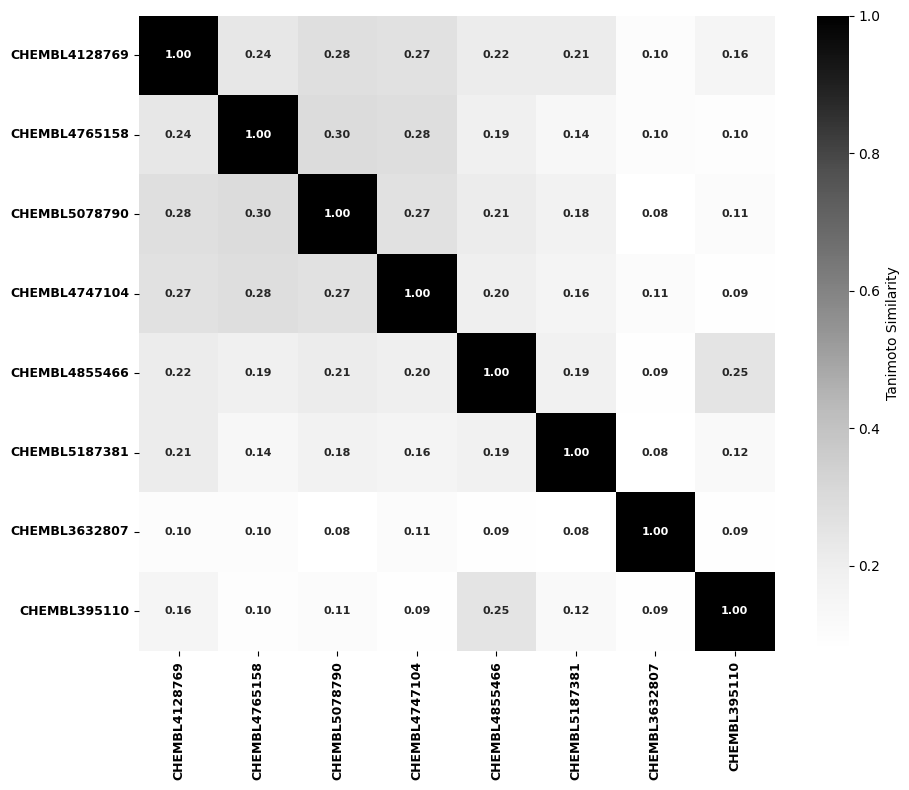


✅ Docking list and heatmap saved to:
C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\4


In [36]:
# ========== SECTION 15: Activity + Drug-Likeness + Clustering Pipeline (Automated RDKit Descriptors) ==========

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Crippen
from rdkit.ML.Cluster import Butina
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# ✅ Step 1: Merge prediction, residual, leverage
df_preds = df_full.copy()
df_preds['Predicted pChEMBL'] = y_pred_best
df_preds['Residuals'] = residuals_best
df_preds['Leverage'] = leverage_best

# ✅ Step 2: Compute leverage threshold
h_star = 3 * (X_train_scaled.shape[1] + 1) / X_train_scaled.shape[0]
print(f"⚠️ Leverage threshold (h*): {h_star:.4f}")

# ✅ Step 3: Filter by applicability domain
df_in_domain = df_preds[df_preds['Leverage'] <= h_star].copy()
print(f"🧪 Total compounds within applicability domain: {df_in_domain.shape[0]}")

# ✅ Step 4: Select top 50% high-activity compounds
top_n = int(0.50 * df_in_domain.shape[0])
df_top_active = df_in_domain.sort_values("Predicted pChEMBL", ascending=False).head(top_n)
print(f"🔥 Top 50% high-activity compounds within domain: {df_top_active.shape[0]}")

# ✅ Step 5: Apply drug-likeness filter (Lipinski + Veber)
def is_drug_like(mol):
    if mol is None:
        return False
    mw = Descriptors.MolWt(mol)
    logp = Crippen.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    rotb = Descriptors.NumRotatableBonds(mol)
    return (mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10 and tpsa <= 140 and rotb <= 10)

df_top_active['Mol'] = df_top_active['Smiles'].apply(Chem.MolFromSmiles)
df_druglike = df_top_active[df_top_active['Mol'].apply(is_drug_like)].copy()
print(f"💊 Drug-like compounds after activity + domain filter: {df_druglike.shape[0]}")

# ✅ Step 6: Compute only model-specific descriptors using RDKit
rdkit_funcs = {name: func for name, func in Descriptors.__dict__.items() if callable(func)}
descriptor_funcs = {name: rdkit_funcs[name] for name in top_features_final if name in rdkit_funcs}

for name, func in descriptor_funcs.items():
    df_druglike[name] = df_druglike['Mol'].apply(func)

# ✅ Step 6.5: Select relevant columns for docking
df_druglike_final = df_druglike[
    ['Smiles', 'Molecule ChEMBL ID', 'pChEMBL Value', 'Predicted pChEMBL', 'Residuals', 'Leverage', 'Mol'] +
    list(descriptor_funcs.keys())
]

# ✅ Step 7: Generate ECFP4 fingerprints
mols = df_druglike_final['Mol'].tolist()
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in mols]

# ✅ Step 8: Compute Tanimoto distance matrix
dists = []
n_fps = len(fps)
for i in range(1, n_fps):
    sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
    dists.extend([1 - x for x in sims])

# ✅ Step 9: Cluster using Butina (cutoff = 0.7)
clusters = Butina.ClusterData(dists, n_fps, 0.7, isDistData=True)
rep_indices = [cluster[0] for cluster in clusters]
print(f"🔗 Total clusters formed: {len(clusters)}")

# ✅ Step 10: Extract representative compounds
df_docking = df_druglike_final.iloc[rep_indices].copy()
print(f"🧬 Selected {len(df_docking)} diverse cluster representatives for docking.")

# ✅ Step 11: Generate Tanimoto similarity matrix
rep_fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in df_docking['Mol']]
sim_matrix = np.zeros((len(rep_fps), len(rep_fps)))
for i in range(len(rep_fps)):
    for j in range(len(rep_fps)):
        sim_matrix[i, j] = DataStructs.TanimotoSimilarity(rep_fps[i], rep_fps[j])

# ✅ Step 12: Plot annotated similarity heatmap (bold labels + values)
ids = df_docking['Molecule ChEMBL ID'].tolist()
plt.figure(figsize=(10, 8))
sns.heatmap(
    sim_matrix,
    cmap='Greys',
    xticklabels=ids,
    yticklabels=ids,
    square=True,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8, "weight": "bold"},
    cbar_kws={'label': 'Tanimoto Similarity'}
)
plt.xticks(rotation=90, fontsize=9, fontweight='bold')
plt.yticks(rotation=0, fontsize=9, fontweight='bold')
plt.tight_layout()

# ✅ Step 13: Save plot and output CSV
save_path = r"C:\\Users\\Haisoj\\Desktop\\PhD Folder\\Thesis\\DLBCL\\ML\\4"
os.makedirs(save_path, exist_ok=True)

plt.savefig(os.path.join(save_path, "Tanimoto_Docking_Heatmap.tiff"), dpi=300)
plt.show()

df_docking.drop(columns=["Mol"], inplace=True)
df_docking.to_csv(os.path.join(save_path, "Docking_Compounds_Selected_Descriptors.csv"), index=False)
print(f"\n✅ Docking list and heatmap saved to:\n{save_path}")

In [42]:
# ===== SECTION: New Compound Descriptor Calculation, Prediction, and Applicability Domain Assessment =====

import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# === Load new design SMILES ===
df_new = pd.read_csv(r"C:\Users\Haisoj\Desktop\PhD Folder\Thesis\DLBCL\ML\4\Design\Optimization\Final USED Design Smiles.csv")
df_new['Mol'] = df_new['SMILE'].apply(Chem.MolFromSmiles)
df_new = df_new[df_new['Mol'].notnull()].copy()

# === Compute all RDKit descriptors ===
all_desc = [desc[0] for desc in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(all_desc)
desc_values = [calc.CalcDescriptors(mol) for mol in df_new['Mol']]
desc_df = pd.DataFrame(desc_values, columns=all_desc)

# Combine with SMILES
desc_df = pd.concat([df_new.reset_index(drop=True), desc_df], axis=1)

# === Filter to top descriptors used in model ===
desc_df = desc_df.dropna(subset=top_features_final)
X_new = desc_df[top_features_final].copy()

# === Scale with training scaler ===
X_new_scaled = scaler_final.transform(X_new)

# === Predict using trained model ===
y_pred_new = model_best.predict(X_new_scaled)

# === Compute Leverage (projected into training space) ===
def add_constant_column(X):
    return np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

X_train_const = add_constant_column(X_train_scaled)   # (n, p+1)
X_new_const = add_constant_column(X_new_scaled)       # (m, p+1)

XTX_inv = np.linalg.inv(X_train_const.T @ X_train_const)

# Leverage: h = xᵢᵀ (XᵀX)^(-1) xᵢ
leverages_new = np.einsum('ij,jk,ik->i', X_new_const, XTX_inv, X_new_const)

# === Calculate consistent leverage threshold ===
h_star = 3 * (X_train_scaled.shape[1] + 1) / X_train_scaled.shape[0]
print(f"📏 Leverage threshold (h*): {h_star:.4f}")

# === Combine prediction results ===
df_results = pd.DataFrame({
    'SMILE': desc_df['SMILE'],
    'Predicted pChEMBL': y_pred_new,
    'Leverage': leverages_new,
    'In Applicability Domain': leverages_new <= h_star
})

# Optional: add descriptors for inspection
for feature in top_features_final:
    df_results[feature] = X_new[feature].values

# === Save results ===
save_path = r"C:\Users\Haisoj\Desktop\PhD Folder\Thesis\DLBCL\ML\4\Design\Optimization"
os.makedirs(save_path, exist_ok=True)

df_results.to_csv(os.path.join(save_path, "New_Design_Prediction_Leverage.csv"), index=False)

print("✅ Done. Results saved to New_Design_Prediction_Leverage.csv")
print(df_results.head())

📏 Leverage threshold (h*): 0.1059
✅ Done. Results saved to New_Design_Prediction_Leverage.csv
                                               SMILE  Predicted pChEMBL  \
0  CC1=CC=C(C=C1)C1=CC2=C(C=CC=N2)C2=CC(=NN12)C(=...           7.066754   
1  CC1=CC=C(CN2C(=O)N(N=C2C2=CC=C(C)C=C2)C(=O)NC2...           6.415180   
2  COC1=CC=C(C=C1)C1=NN(C(=O)NC2CCCCC2)C(=O)N1C1=...           6.465526   
3  CN1N=C(C(=O)NC2C[C@@H]3CCC[C@@H](C2)N3C)C2=CC=...           5.899799   

   Leverage  In Applicability Domain  fr_pyridine           Ipc  BCUT2D_MRLOW  \
0  0.044547                     True            2  8.865327e+06      0.092210   
1  0.031581                     True            0  8.570643e+06      0.230005   
2  0.040871                     True            0  9.376084e+06      0.230111   
3  0.081114                     True            0  1.879561e+07      0.046189   

   PEOE_VSA11  PEOE_VSA4  NumAtomStereoCenters  SlogP_VSA7  VSA_EState5  
0    5.693928   5.098682                     0    